## LandCover Demo - Using the ArcGIS Python API
This notebook reviews the workflow for extracting land cover data for a spatially selected watershed.

### Pseudocode
* Get the user point, as lat/long coordinates (Alternatively, geocode address)
* Identify the HUC12 in which it is located
 * Search AGOL for a watershed boundary datatset
 * Retrive the HUC12 layer from the results
 * Query the HUC12 intersecting the user point and report its HUC8 value
* Extract land cover within the selected HUC
 * Browse Living Atlas for an appropriate land cover dataset (NLCD)
 * Retrieve the land cover as an imagery service
 * Filter the images for a specific time
 * Extract the histogram for the pixels within the geometry

In [1]:
#Import arcgis modules
from arcgis import GIS
from arcgis.geocoding import geocode
from arcgis.features import FeatureLayer, GeoAccessor
from arcgis.raster import ImageryLayer
from arcgis.geometry import Point, filters

#Import pandas
import pandas as pd

#Connect to AGOL
gis = GIS('home')

### Create the selection point and the point filter

In [4]:
# Set user coordinates
userLat = 36.0010
userLng = -78.9991

In [5]:
#Create the point object
the_pt = Point({
    "x" : userLng, 
    "y" : userLat, 
    "spatialReference" : {"wkid" : 4326}
})

In [6]:
#Create a filter object from our point
point_filter = filters.intersects(the_pt)

### Fetch the on-line data

In [2]:
#Fetch the HUC12 Feature Layer
huc_layer = FeatureLayer(
    url='https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/Watershed_Boundary_Dataset_HUC_12s/FeatureServer/0'
)

In [3]:
#Fetch the NLCD Imagery Layer
nlcd_layer = ImageryLayer(
    url='https://landscape10.arcgis.com/arcgis/rest/services/USA_NLCD_Land_Cover/ImageServer',
    gis=gis
)

### Analysis

In [32]:
#Spatially query the layer and convert to spatial dataframe
huc_sdf = huc_layer.query(geometry_filter=point_filter).sdf
huc_sdf

,OBJECTID,HUC12,NAME,HUTYPE,NONCONTRIBUTINGACRES,NONCONTRIBUTINGSQKM,Shape__Area,Shape__Length,SHAPE
0,92485,030300020601,Headwaters New Hope Creek,S,0.0,0.0,206318556.871094,91005.33812,"{""rings"": [[[-8803555.3275, 4304288.8763], [-8..."


In [8]:
#Get the feature geometry
huc_geom = huc_sdf.loc[0,'SHAPE']

In [23]:
#Query the imagery layer
selected_images = nlcd_layer.filter_by(
    where="Name = 'USA_NLCD_Land_Cover_2016_conus'",    #Filter for just USA_NLCD_Land_Cover_2016_conus
    geometry=filters.intersects(huc_geom),              #Filter for datasets that intersect the geometry
    lock_rasters=True
)

In [24]:
#Extract the values within the selected geometry
the_histogram = selected_images.compute_histograms(
    geometry=huc_geom,
    pixel_size=30)

In [26]:
#Extract just the counts
the_counts = the_histogram['histograms'][0]['counts']

#Convert the counts to a dataframe
df_results = pd.DataFrame(the_counts,columns=['Count'])

In [30]:
#Fetch the NLCD land cover classes
df_classes = pd.read_csv(
    'https://raw.githubusercontent.com/ENV859/ArcGIS-PythonAPI/refs/heads/master/data/NLCD.csv',
     index_col=0)

### Results

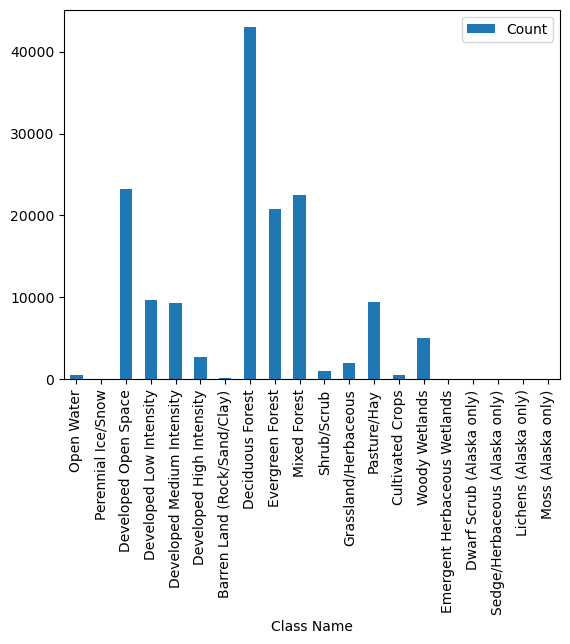

In [31]:
#Merge with the classes DataFrame
df_histo = pd.merge(df_classes, df_results, left_index=True, right_index=True)
df_histo.plot.bar(x='Class Name', y='Count');